## Modeling Questions


* F1 score, when under 33%, is simply atrocious. All smokers in SVC.
* I SHOULD consider going back to drinking & drugs adding in.
* If I add new features, I need to re-run all models.
* **train_test_split STRATIFIED before SMOTE, then only SMOTE the train set?**
  * do new .ipynb doing SMOTE and sampling!
* calculate area under the curve.  

#### KNN
* Lazy
* Fits **fast**, predicts **slow**
* Fits d-dimensional data in `O(dn)` time
* Higher memory (saves entire data set)
* Various implementations (weighted, uniform)


In [400]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
# import pymc3 as pm
import seaborn as sns

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'png'
# mpl.rcParams['figure.dpi']= 300

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 60)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import sklearn
from sklearn.preprocessing import StandardScaler, Binarizer, LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate \
                                    ,cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix,recall_score,precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_curve, auc

import itertools
from sklearn.metrics import confusion_matrix

# Helper Functions

In [687]:
target_names=['does not smoke','smokes']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def confusion_matrices(y_pred):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names,
                          title='Confusion matrix, without normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                          title='Confusion matrix, Normalized')

In [688]:
def plot_roc_curve(fit_model, title):
    y_score=fit_model.predict_proba(X_test)[:,1]
    fpr, tpr,_ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    # Plotting the Baseline
    plt.plot([0,1],[0,1])
    plt.plot(fpr,tpr)
    plt.grid(which='major')
    plt.title(f"{title} ROC curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate');

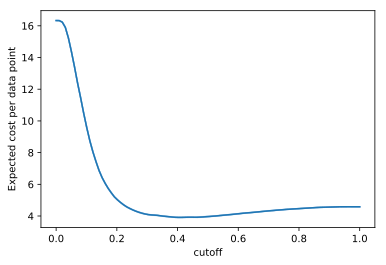

In [689]:
def makecost(obs,prob,falsepos_cost,falseneg_cost):
    def cost(cutoff):
        pred = np.array(prob > cutoff)
        fpos = pred * (1 - obs) 
        fneg = (1 - pred) * obs
        return np.sum(fpos * falsepos_cost + fneg * falseneg_cost)
    return np.vectorize(cost)

cut = np.linspace(0,1,100)
cost = np.zeros_like(cut)
from sklearn.model_selection import KFold, cross_val_predict
obs = np.ravel(y)

K = 20
for j in range(K):
    folds = KFold(n_splits=5,shuffle=True)
    prob = cross_val_predict(logreg,X,np.ravel(y),cv=folds,method='predict_proba',n_jobs=5)[:,1]
    getcost = makecost(obs,prob,falsepos_cost=20,falseneg_cost=25)
    currentcost = getcost(cut)/X.shape[0]
    cost += currentcost
    plt.plot(cut, currentcost,c='C0',alpha=0.05)
cost /= K
plt.plot(cut,cost,c='C0')
plt.xlabel('cutoff')
plt.ylabel('Expected cost per data point');

# Load Data

In [2]:
cupid = load_pd_pkl('data/cupid_cleaned')

In [517]:
target = ['binary_smokes']
continuous = ['age', 'height']
# bi_categorical = ['sex', 'wants_kids', 'signs_fun', 'signs_unimportant', 'signs_important',
#                      'religion_unserious', 'religion_laughing', 'religion_somewhat',
#                      'religion_serious', ]
# mult_categorical = ['body_type', 'drinks', 'drugs', 'income', 'orientation', 'status',
#                       'diet_intensity', 'diet_choice', 'primary_ethnicity',
#                       'has_kids','likes_cats', 'likes_dogs', 'dislikes_cats', 'dislikes_dogs',
#                       'has_cats', 'has_dogs','english_fluent','english_poor','spanish_fluent',
#                       'spanish_not_poorly','religion_name','new_education',]



# remove from bi: 'signs_fun', 'signs_unimportant', 'signs_important', 'religion_unserious', 'religion_laughing', 'religion_somewhat',
#                     'religion_serious',

bi_categorical = ['sex', 'wants_kids',
                    ]

# remove from multi:  'new_education','likes_cats', 'likes_dogs', 'dislikes_cats', 
#          'dislikes_dogs', 'has_cats', 'has_dogs', 'primary_ethnicity', , 
#          'english_fluent','english_poor','spanish_fluent','spanish_not_poorly',
#          'diet_intensity', 'diet_choice', 'religion_name'
                      
mult_categorical = ['body_type', 'income', 'orientation', 'status',
                      'has_kids', 'drinks', 'drugs',]


# Assign feature groupings
columns = bi_categorical + mult_categorical + target

# Create DF of everything
df = cupid[target + continuous + bi_categorical + mult_categorical]

### Change data type of age
df['age'] = df.age.astype(float)

df = df.dropna()

# Split DF of only standardized/scaled features
scaled_features = df.copy().loc[:, continuous]

# Tranform age and height (standardized features)
features = scaled_features[continuous]
features = StandardScaler().fit_transform(features.values)
scaled_features[continuous] = features

# Create dummy variables for original features, then combine back with scaled features
dummies = pd.get_dummies(df.loc[:, columns], columns=columns, drop_first=False)
df = scaled_features.join(dummies)

# Drop all "placeholder" columns
df.drop(df.filter(regex='placeholder'), axis=1, inplace=True)

# Drop "No" smoking column
df.drop(columns="binary_smokes_no", axis=1, inplace=True)

# SETUP MODELING DATA

X = df.drop('binary_smokes_yes', axis=1)
y = df['binary_smokes_yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

/home/spencer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


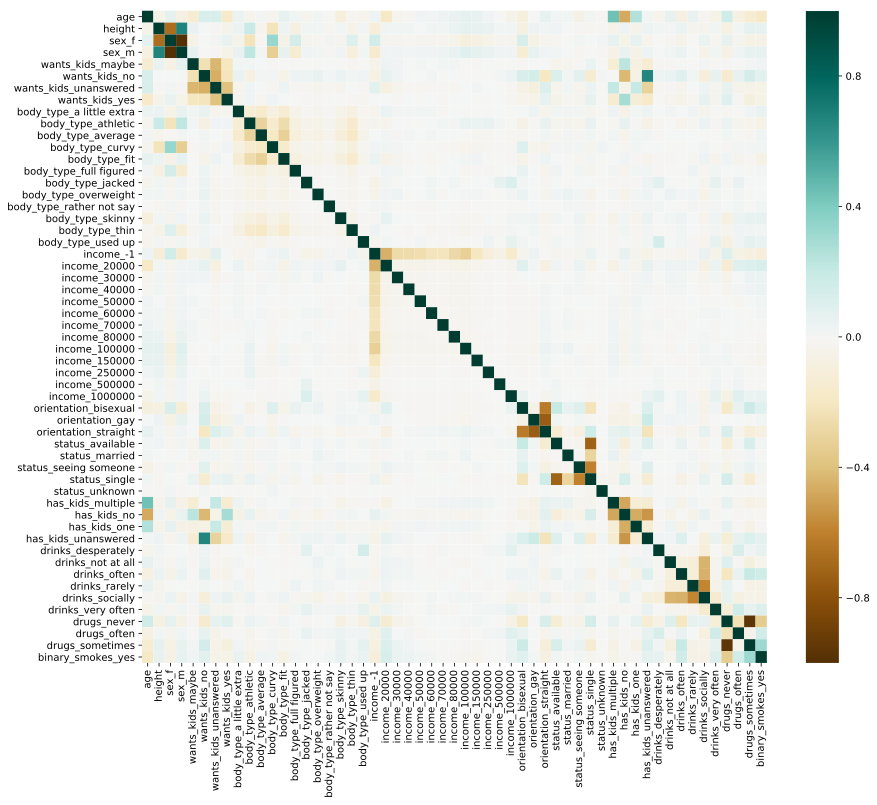

In [653]:
fig, ax = plt.subplots(figsize=(14,12))
sns.heatmap(df.corr(), xticklabels=True, cmap='BrBG');

In [519]:
df.shape

(17625, 55)

In [654]:
no, yes = df.binary_smokes_yes.value_counts()

In [655]:
no / (no+ yes)

0.8166241134751773

# K-Nearest Neighbors (KNN)

## GridSearchCV

### Warning, this is quite computationally heavy! (30+ minutes)


### A few RandomizedSearchCV searches helped me narrow the range to between K = 1-8. Both uniform and distance were the best results for weight.

In [529]:
knn = KNeighborsClassifier()

# define the parameter values that should be searched
k_range = list(range(1, 7))
weight_options = ['uniform', 'distance']

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, weights=weight_options)
# print(param_grid)

# instantiate the grid
grid_knn = GridSearchCV(knn, param_grid, cv=10, scoring='f1', n_jobs=5)

# fit the grid with data
grid_knn.fit(X_train, y_train);

# examine the best model
print(grid_knn.best_score_)
print(grid_knn.best_params_)
print(grid_knn.best_estimator_)

0.3254047979078492
{'n_neighbors': 3, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')


In [701]:
y_pred_knn = grid_knn.predict(X_test)
print("test f1:", metrics.f1_score(y_test, y_pred_knn))
print("test accuracy:", metrics.accuracy_score(y_test, y_pred_knn))

test f1: 0.3396971691902567
test accuracy: 0.8103252647503782


classification report: 

                precision    recall  f1-score   support

does not smoke       0.85      0.93      0.89      4318
        smokes       0.47      0.27      0.34       970

     micro avg       0.81      0.81      0.81      5288
     macro avg       0.66      0.60      0.61      5288
  weighted avg       0.78      0.81      0.79      5288

Confusion matrix, without normalization
[[4027  291]
 [ 712  258]]
Normalized confusion matrix
[[0.93 0.07]
 [0.73 0.27]]


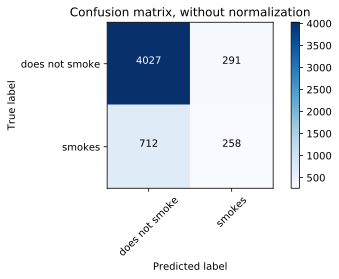

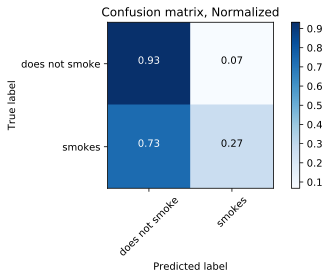

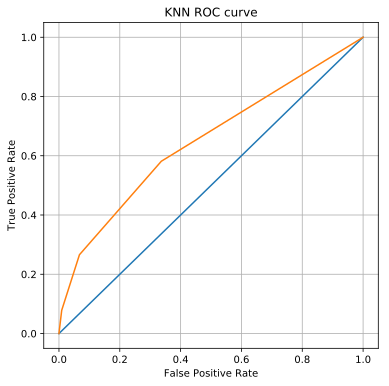

In [702]:
print("classification report: \n")
print(metrics.classification_report(y_test, y_pred_knn, target_names=['does not smoke','smokes']))
confusion_matrices(y_pred_knn)
plot_roc_curve(grid_knn, 'KNN')

### Now messing with THRESHOLD

In [721]:
y_prob = grid_knn.predict_proba(X_test)

y_pred_knn_prob = y_prob[:,1] >= 0.3

print(metrics.classification_report(y_test, y_pred_knn_prob, target_names=['does not smoke','smokes']))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_knn_prob))

                precision    recall  f1-score   support

does not smoke       0.88      0.66      0.76      4318
        smokes       0.28      0.58      0.38       970

     micro avg       0.65      0.65      0.65      5288
     macro avg       0.58      0.62      0.57      5288
  weighted avg       0.77      0.65      0.69      5288

accuracy:  0.6484493192133132


Confusion matrix, without normalization
[[2865 1453]
 [ 406  564]]
Normalized confusion matrix
[[0.66 0.34]
 [0.42 0.58]]


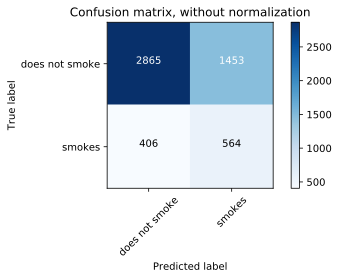

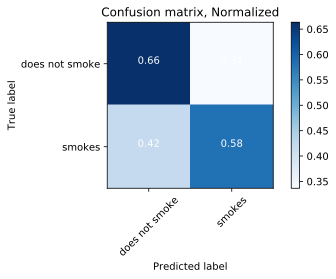

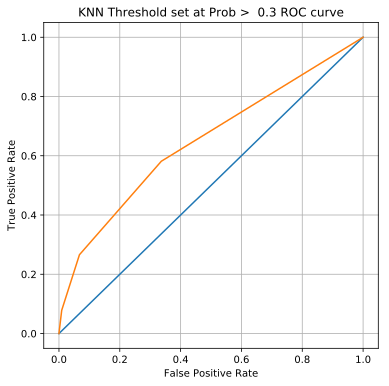

In [752]:
confusion_matrices(y_pred_knn_prob)
plot_roc_curve(grid_knn, 'KNN Threshold set at Prob >  0.3')

# Logistic Regression

In [757]:
logreg = LogisticRegression(max_iter=500, random_state=42)
# define the parameter values that should be searched
C_options = [2]
duals = [False]
tol_options = [1e-3]
pen_options = ['l2']
solver_options = ['liblinear']

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(C=C_options, dual=duals, tol=tol_options, penalty=pen_options, solver=solver_options)
# print(param_grid)

# instantiate the grid
grid_lr = GridSearchCV(logreg, param_grid, cv=10, scoring='f1', n_jobs=6)

# fit the grid with data
grid_lr.fit(X_train, y_train);

# examine the best model
print(grid_lr.best_score_)
print(grid_lr.best_params_)
print(grid_lr.best_estimator_)

0.3826356997969589
{'C': 2.0, 'dual': False, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.001}
LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.001, verbose=0, warm_start=False)


In [758]:
y_pred_logreg = grid_lr.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_logreg))

print(metrics.classification_report(y_test, grid.predict(X_test)))

0.8316944024205749
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      4318
           1       0.58      0.27      0.37       970

   micro avg       0.83      0.83      0.83      5288
   macro avg       0.72      0.61      0.64      5288
weighted avg       0.80      0.83      0.80      5288



Confusion matrix, without normalization
[[4143  175]
 [ 715  255]]
Normalized confusion matrix
[[0.96 0.04]
 [0.74 0.26]]


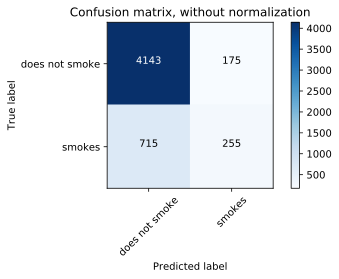

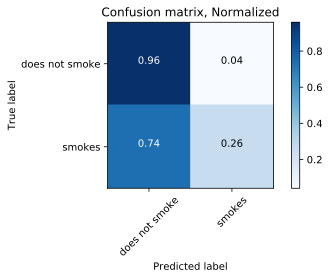

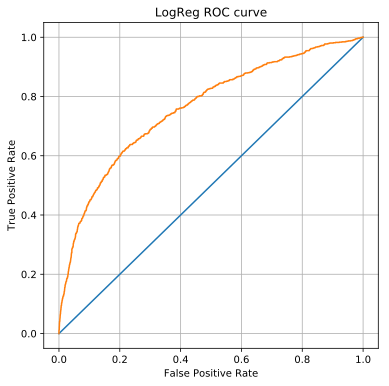

In [760]:
confusion_matrices(y_pred_logreg)

plot_roc_curve(grid_lr, "LogReg")

### Now messing with THRESHOLD

In [761]:
y_prob = grid_lr.predict_proba(X_test)

y_pred_lr_prob = y_prob[:,1] >= 0.25

print(metrics.classification_report(y_test, y_pred_lr_prob, target_names=['does not smoke','smokes']))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_lr_prob))

                precision    recall  f1-score   support

does not smoke       0.89      0.86      0.87      4318
        smokes       0.45      0.51      0.48       970

     micro avg       0.80      0.80      0.80      5288
     macro avg       0.67      0.69      0.68      5288
  weighted avg       0.81      0.80      0.80      5288

accuracy:  0.7957639939485628


Confusion matrix, without normalization
[[3710  608]
 [ 472  498]]
Normalized confusion matrix
[[0.86 0.14]
 [0.49 0.51]]


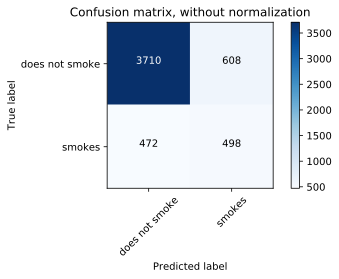

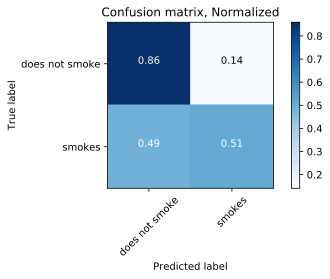

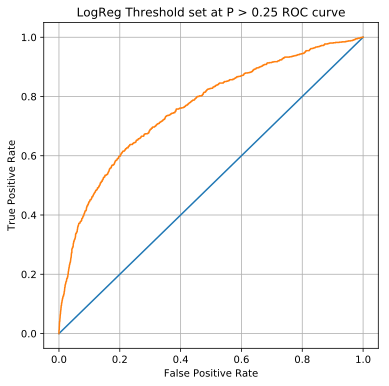

In [762]:
confusion_matrices(y_pred_lr_prob)
plot_roc_curve(grid_lr, 'LogReg Threshold set at P > 0.25')

# Support Vector Machine (SVM)

In [769]:
svm = SVC(probability = True, random_state=42)

Cs=[1.75]
kernels = ['rbf']
gammas = ['scale']
tols = [1e-5]

# Cs=[.75, 1, 1.25, 1.5, 2]
# kernels = ['linear','rbf','sigmoid']
# gammas = ['scale', 'auto']
# tols = [.00001, .0001, .001, .01,]

param_grid = dict(C=Cs, tol=tols, gamma=gammas, kernel=kernels)

grid_svm = GridSearchCV(svm, param_grid, cv=10, scoring='f1', n_jobs=-1)

grid_svm.fit(X_train, y_train)

print(grid_svm.best_score_)
print(grid_svm.best_params_)
print(grid_svm.best_estimator_)

0.39003283427060204
{'C': 1.75, 'gamma': 'scale', 'kernel': 'rbf', 'tol': 1e-05}
SVC(C=1.75, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=1e-05, verbose=False)


In [770]:
y_pred_best_svm = grid_svm.predict(X_test)

print(metrics.classification_report(y_test, y_pred_best_svm))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      4318
           1       0.59      0.26      0.36       970

   micro avg       0.83      0.83      0.83      5288
   macro avg       0.72      0.61      0.63      5288
weighted avg       0.80      0.83      0.80      5288



In [771]:
metrics.accuracy_score(y_test, y_pred_best_svm)

0.8311270801815431

Confusion matrix, without normalization
[[4143  175]
 [ 718  252]]
Normalized confusion matrix
[[0.96 0.04]
 [0.74 0.26]]


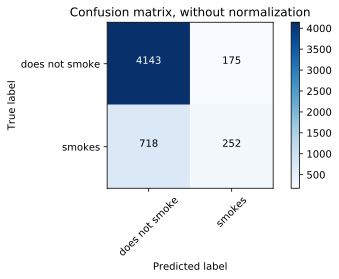

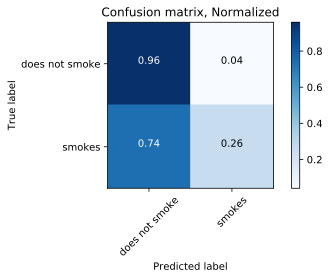

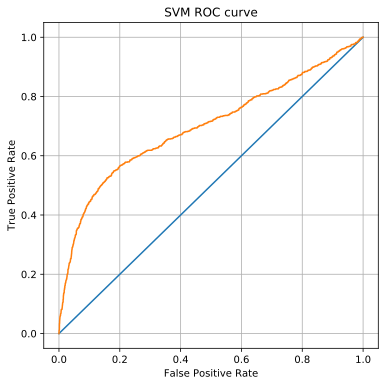

In [772]:
confusion_matrices(y_pred_best_svm)

plot_roc_curve(grid_svm, 'SVM')

### Now messing with THRESHOLD

In [784]:
y_prob = grid_svm.predict_proba(X_test)

y_pred_svm_prob = y_prob[:,1] > 0.144

print(metrics.classification_report(y_test, y_pred_svm_prob, target_names=['does not smoke','smokes']))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_svm_prob))

                precision    recall  f1-score   support

does not smoke       0.88      0.90      0.89      4318
        smokes       0.50      0.45      0.47       970

     micro avg       0.82      0.82      0.82      5288
     macro avg       0.69      0.67      0.68      5288
  weighted avg       0.81      0.82      0.81      5288

accuracy:  0.8150529500756429


Confusion matrix, without normalization
[[3878  440]
 [ 538  432]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.55 0.45]]


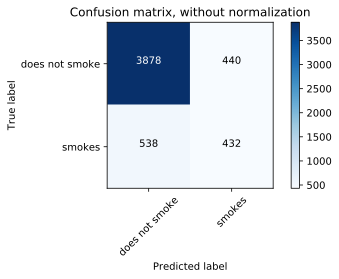

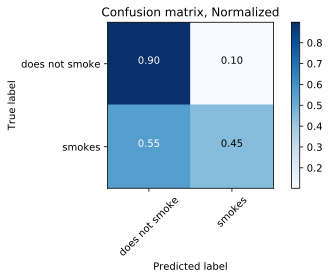

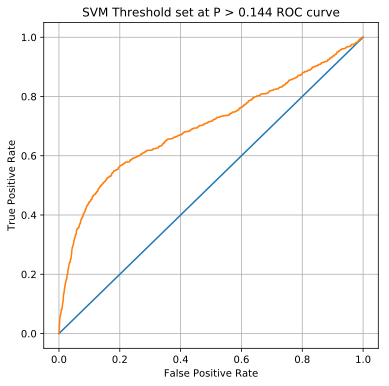

In [785]:
confusion_matrices(y_pred_svm_prob)
plot_roc_curve(grid_svm, 'SVM Threshold set at P > 0.144')

# Decision Trees

In [611]:
dt = DecisionTreeClassifier(random_state=42)

criterions = ['gini', 'entropy']    

param_grid = dict(criterion=criterions)

grid_dt = GridSearchCV(dt, param_grid, scoring='f1', cv=10, n_jobs=5)

grid_dt.fit(X_train, y_train)

print(grid_dt.best_score_)
print(grid_dt.best_params_)
print(grid_dt.best_estimator_)

0.34370064766261665
{'criterion': 'entropy'}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


In [614]:
y_pred_dtree = grid_dt.predict(X_test)

print(metrics.classification_report(y_test, y_pred_dtree))
print('accuracy:', metrics.accuracy_score(y_test, y_pred_dtree))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4318
           1       0.35      0.36      0.36       970

   micro avg       0.76      0.76      0.76      5288
   macro avg       0.61      0.61      0.61      5288
weighted avg       0.76      0.76      0.76      5288

accuracy: 0.7617246596066566


Confusion matrix, without normalization
[[3676  642]
 [ 618  352]]
Normalized confusion matrix
[[0.85 0.15]
 [0.64 0.36]]


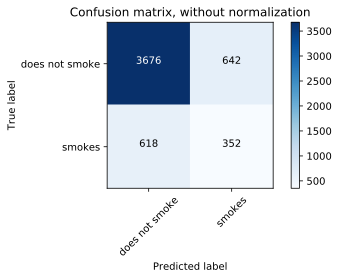

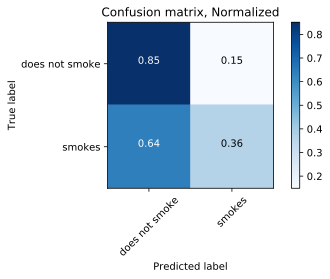

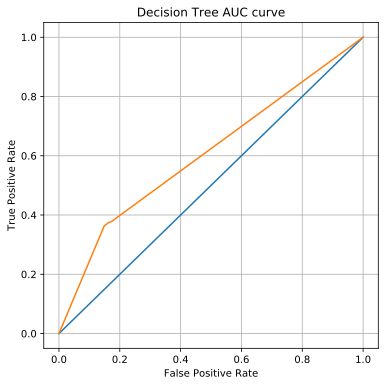

In [615]:
confusion_matrices(grid_dt)

plot_roc_curve(grid_dt, "Decision Tree")

### Now messing with THRESHOLD - Nothing in Decision Tree matters.

In [791]:
y_prob = grid_dt.predict_proba(X_test)

y_pred_dt_prob = y_prob[:,1] > 0.5

print(metrics.classification_report(y_test, y_pred_dt_prob, target_names=['does not smoke','smokes']))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_dt_prob))

                precision    recall  f1-score   support

does not smoke       0.86      0.85      0.85      4318
        smokes       0.35      0.36      0.36       970

     micro avg       0.76      0.76      0.76      5288
     macro avg       0.61      0.61      0.61      5288
  weighted avg       0.76      0.76      0.76      5288

accuracy:  0.7617246596066566


Confusion matrix, without normalization
[[3710  608]
 [ 472  498]]
Normalized confusion matrix
[[0.86 0.14]
 [0.49 0.51]]


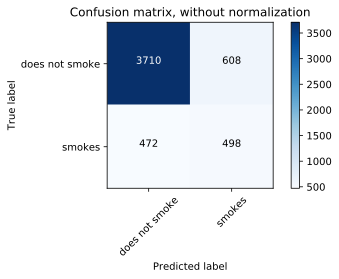

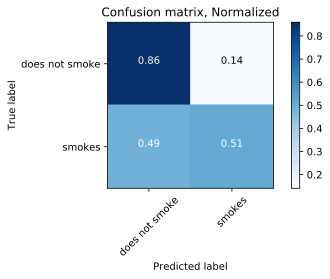

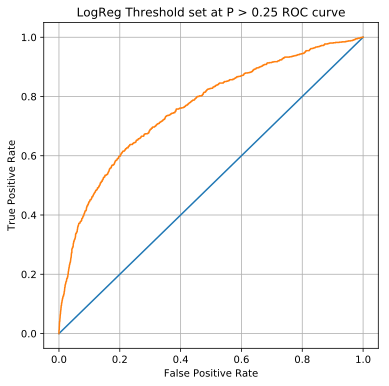

In [762]:
confusion_matrices(y_pred_dt_prob)
plot_roc_curve(grid_dt, 'DT Threshold set at P > 0.5')

# Random Forrest

In [623]:
rf = RandomForestClassifier(random_state=42)

criterions = ['gini', 'entropy']
n_ests = [200, 300, 500, 1000]
    
param_grid = dict(criterion=criterions, n_estimators=n_ests)

grid_rf = GridSearchCV(rf, param_grid, scoring='f1', cv=10, n_jobs=5)

grid_rf.fit(X_train, y_train)

print(grid_rf.best_score_)
print(grid_rf.best_params_)
print(grid_rf.best_estimator_)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.3605376885303103
{'criterion': 'gini', 'n_estimators': 500}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


In [629]:
y_pred_rf = grid_rf.predict(X_test)

print(metrics.classification_report(y_test, y_pred_rf))
print('accuracy:', metrics.accuracy_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4318
           1       0.49      0.28      0.36       970

   micro avg       0.82      0.82      0.82      5288
   macro avg       0.67      0.61      0.63      5288
weighted avg       0.79      0.82      0.79      5288

accuracy: 0.8154311649016641


In [630]:
grid_rf.predict_proba(X_test)

array([[0.81, 0.19],
       [0.18, 0.82],
       [0.39, 0.61],
       ...,
       [0.94, 0.06],
       [0.96, 0.04],
       [0.13, 0.87]])

Confusion matrix, without normalization
[[4040  278]
 [ 698  272]]
Normalized confusion matrix
[[0.94 0.06]
 [0.72 0.28]]


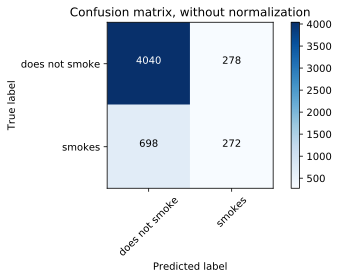

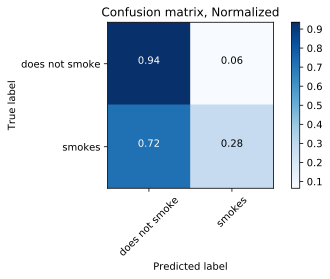

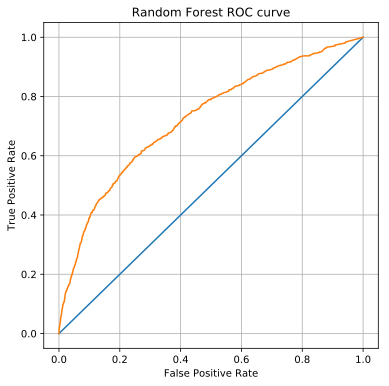

In [631]:
confusion_matrices(grid_rf)
plot_roc_curve(grid_rf, "Random Forest")

### Now messing with THRESHOLD

In [805]:
y_prob = grid_rf.predict_proba(X_test)

y_pred_rf_prob = y_prob[:,1] > 0.35

print(metrics.classification_report(y_test, y_pred_rf_prob, target_names=['does not smoke','smokes']))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_rf_prob))

                precision    recall  f1-score   support

does not smoke       0.88      0.87      0.87      4318
        smokes       0.44      0.45      0.44       970

     micro avg       0.79      0.79      0.79      5288
     macro avg       0.66      0.66      0.66      5288
  weighted avg       0.79      0.79      0.79      5288

accuracy:  0.7921709531013615


Confusion matrix, without normalization
[[3752  566]
 [ 533  437]]
Normalized confusion matrix
[[0.87 0.13]
 [0.55 0.45]]


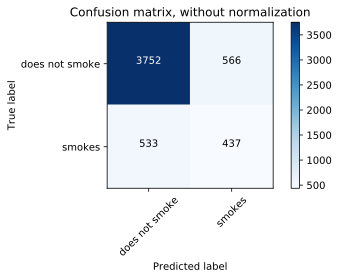

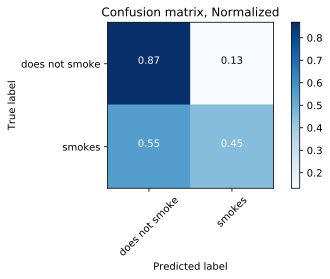

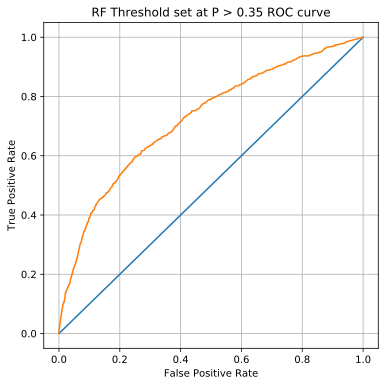

In [806]:
confusion_matrices(y_pred_rf_prob)
plot_roc_curve(grid_rf, 'RF Threshold set at P > 0.35')

# Gradient Boosting

In [632]:
gb = GradientBoostingClassifier(random_state=42)

losses = ['deviance']
lrs = [.5, 1]
n_ests = [200, 300]
subsamples=[0.25, 0.5, 0.75, 1]
# criterions=[
# mins=[
# minl=[
maxd = [3, 5]
tols = [.0001]
    
    

param_grid = dict(loss=losses, learning_rate=lrs, n_estimators=n_ests, subsample=subsamples,
                 max_depth=maxd, tol=tols)

grid_gb = GridSearchCV(gb, param_grid, scoring='f1', cv=10, n_jobs=6)

grid_gb.fit(X_train, y_train)

print(grid_gb.best_score_)
print(grid_gb.best_params_)
print(grid_gb.best_estimator_)

0.39193484988222127
{'learning_rate': 0.5, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 200, 'subsample': 1, 'tol': 0.0001}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False)


In [633]:
y_pred_gb = grid_gb.predict(X_test)

metrics.f1_score(y_test, y_pred_gb)

0.37869822485207105

In [634]:
print(metrics.classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      4318
           1       0.52      0.30      0.38       970

   micro avg       0.82      0.82      0.82      5288
   macro avg       0.69      0.62      0.64      5288
weighted avg       0.79      0.82      0.80      5288



Confusion matrix, without normalization
[[4055  263]
 [ 682  288]]
Normalized confusion matrix
[[0.94 0.06]
 [0.7  0.3 ]]


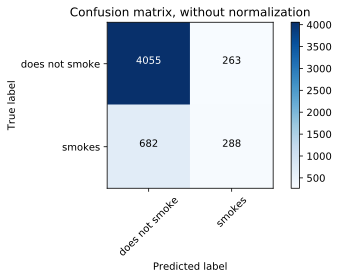

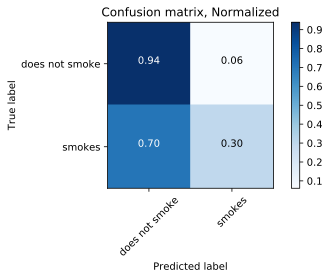

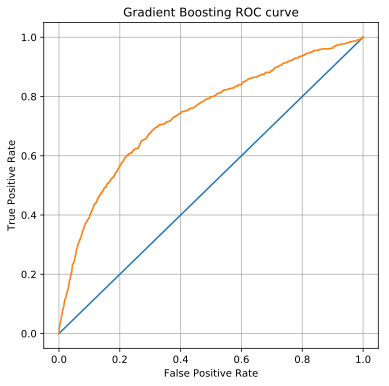

In [636]:
confusion_matrices(grid_gb)
plot_roc_curve(grid_gb, "Gradient Boosting")

### Now messing with THRESHOLD

In [835]:
y_prob = grid_gb.predict_proba(X_test)

y_pred_gb_prob = y_prob[:,1] > 0.28

print(metrics.classification_report(y_test, y_pred_gb_prob, target_names=['does not smoke','smokes']))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_gb_prob))

                precision    recall  f1-score   support

does not smoke       0.88      0.87      0.87      4318
        smokes       0.44      0.47      0.45       970

     micro avg       0.79      0.79      0.79      5288
     macro avg       0.66      0.67      0.66      5288
  weighted avg       0.80      0.79      0.79      5288

accuracy:  0.7923600605143721


Confusion matrix, without normalization
[[3736  582]
 [ 516  454]]
Normalized confusion matrix
[[0.87 0.13]
 [0.53 0.47]]


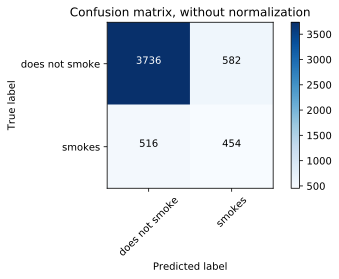

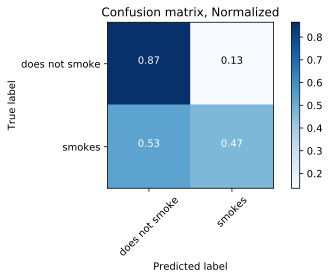

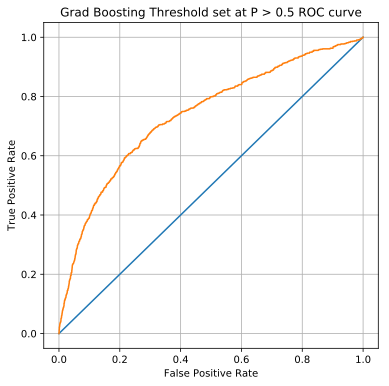

In [836]:
confusion_matrices(y_pred_gb_prob)
plot_roc_curve(grid_gb, 'Grad Boosting Threshold set at P > 0.28')

# Naive Bayes

In [637]:
nb = GaussianNB()

nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [638]:
y_pred_nb = nb.predict(X_test)

In [639]:
metrics.f1_score(y_test, y_pred_nb)

0.43293954134815843

In [640]:
print(metrics.classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.90      0.70      0.79      4318
           1       0.33      0.64      0.43       970

   micro avg       0.69      0.69      0.69      5288
   macro avg       0.61      0.67      0.61      5288
weighted avg       0.79      0.69      0.72      5288



Confusion matrix, without normalization
[[3033 1285]
 [ 347  623]]
Normalized confusion matrix
[[0.7  0.3 ]
 [0.36 0.64]]


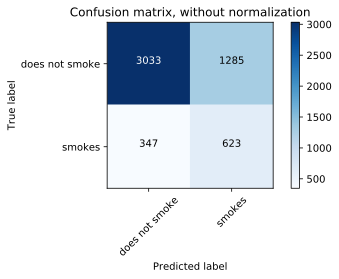

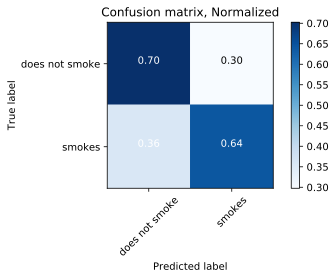

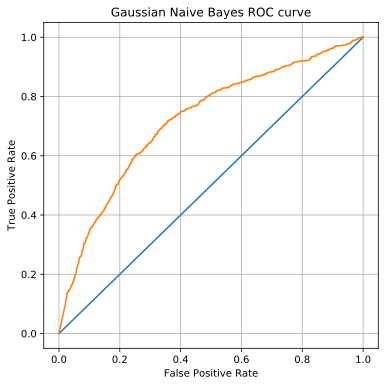

In [642]:
confusion_matrices(nb)
plot_roc_curve(nb, "Gaussian Naive Bayes")

### Now messing with THRESHOLD

In [870]:
y_prob = nb.predict_proba(X_test)

y_pred_nb_prob = y_prob[:,1] > 0.7


print(metrics.classification_report(y_test, y_pred_nb_prob, target_names=['does not smoke','smokes']))
print("accuracy: ", metrics.accuracy_score(y_test, y_pred_nb_prob))

                precision    recall  f1-score   support

does not smoke       0.90      0.72      0.80      4318
        smokes       0.33      0.62      0.44       970

     micro avg       0.70      0.70      0.70      5288
     macro avg       0.61      0.67      0.62      5288
  weighted avg       0.79      0.70      0.73      5288

accuracy:  0.7027231467473525


Confusion matrix, without normalization
[[3110 1208]
 [ 364  606]]
Normalized confusion matrix
[[0.72 0.28]
 [0.38 0.62]]


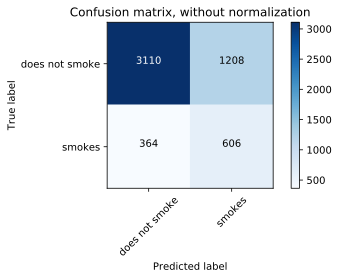

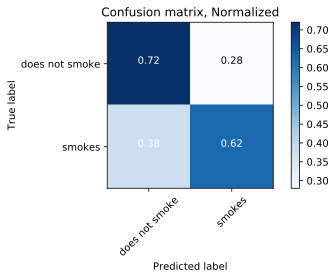

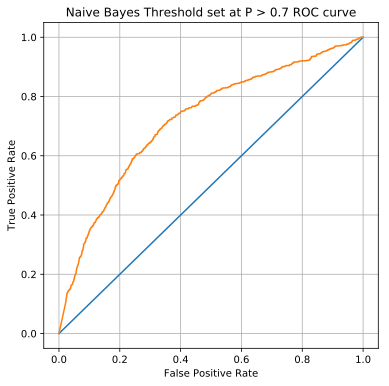

In [872]:
confusion_matrices(y_pred_nb_prob)
plot_roc_curve(nb, 'Naive Bayes Threshold set at P > 0.7')

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4))
fig.set_figwidth(10)
fig.set_figheight(6)

fig.suptitle('Main Title',fontsize = 16)

ax[0].plot(new_x,new_y)
ax[0].set_title('Line Chart')

ax[1].bar(new_x,new_y)
ax[1].set_title('Bar Chart');